강의_6기_AI응용_5차시_02_transfer_learning_alexnet_20251126.ipynb

In [12]:
# 운영 체제와 상호 작용하는 함수(예: 파일 경로 처리)를 제공하는 모듈을 불러옴.
import os
# 시간 관련 함수(예: 딜레이, 시간 측정)를 제공하는 모듈을 불러옴.
import time
# 객체를 깊은 복사(deep copy)하기 위한 모듈을 불러옴. 모델 가중치 복사 등에 유용함.
import copy
# NumPy 라이브러리를 np 별칭으로 불러옴. 배열 및 수치 연산에 사용함.
import numpy as np
# Matplotlib의 pyplot 모듈을 plt 별칭으로 불러옴. 데이터 시각화에 사용함.
import matplotlib.pyplot as plt
# PyTorch 핵심 라이브러리를 불러옴. 딥러닝 모델 구축에 사용함.
import torch
# TorchVision 라이브러리를 불러옴. 비전 관련 데이터셋과 모델 등을 제공함.
import torchvision
# 신경망 레이어(nn) 모듈을 불러옴. 모델의 구성 요소를 정의함.
import torch.nn as nn
# 옵티마이저(optim) 모듈을 불러옴. 모델 학습 시 가중치 업데이트에 사용함.
import torch.optim as optim
# 학습률 스케줄러(lr_scheduler) 모듈을 불러옴. 학습 중에 학습률을 동적으로 조정함.
from torch.optim import lr_scheduler
# TorchVision에서 데이터셋, 미리 학습된 모델, 데이터 변환(transforms) 모듈을 불러옴.
from torchvision import datasets, models, transforms
# PyTorch의 난수 생성기 시드(seed) 값을 0으로 설정했음. 결과의 재현성을 보장함.
torch.manual_seed(0)

In [13]:
!pip install Kaggle

In [14]:
# 파일 업로드 창이 열립니다. 여기서 kaggle.json 파일을 선택하여 업로드합니다.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"chcheon","key":"46db6939ca949559c4972c4b9e599f03"}'}

In [15]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/          # api key 인증키 이동
!chmod 600 ~/.kaggle/kaggle.json    # 파일접근권한(본인만 읽고(4), 쓰기(2) 가능)

In [16]:
!kaggle datasets download -d ajayrana/hymenoptera-data
!unzip -q hymenoptera-data.zip -d . # . 의미 : 현재 디렉터리

Dataset URL: https://www.kaggle.com/datasets/ajayrana/hymenoptera-data
License(s): CC0-1.0
hymenoptera-data.zip: Skipping, found more recently modified local copy (use --force to force download)
replace ./hymenoptera_data/hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:  N
error:  invalid response [ N]
replace ./hymenoptera_data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
# 데이터셋이 위치한 root directory dlfmawjddml
ddir = 'hymenoptera_data'

# 학습과 검증 데이터셋에 적용할 이미지 전처리
data_transformers = {
 'train' : transforms.Compose([
     transforms.RandomResizedCrop(224), # 무작위로 자르고 크기 조정
     transforms.RandomHorizontalFlip(), # 좌우반전

     transforms.ToTensor(),
     transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
 ]),
 'val' : transforms.Compose([
     transforms.Resize(256),
     transforms.CenterCrop(224),

     transforms.ToTensor(),
     transforms.Normalize([0.490, 0.449, 0.411], [0.231, 0.221, 0.230])
 ])
}

In [21]:
# 'train'과 'val' 디렉터리에서 ImageFolder 데이터셋 로드
# 폴더명(클래스)와 이미지 매핑 >> 해당 전처리 적용
img_data = {k: datasets.ImageFolder(os.path.join(ddir, k), data_transformers[k]) for k in {'train', 'val'}}
print(img_data)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.49, 0.449, 0.411], std=[0.231, 0.221, 0.23])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.49, 0.449, 0.411], std=[0.231, 0.221, 0.23])
           )}


In [36]:
# batch_size = 8, 데이터 섞기, 작업자 수 2
dloaders = {k: torch.utils.data.DataLoader(img_data[k], batch_size=8, shuffle=(True if k == 'train' else False), num_workers=2) for k in {'train', 'val'}}
dset_sizes = {k: len(img_data[k]) for k in ['train', 'val']}
classes = img_data['train'].classes
dvc = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imageshow(img, text=None):
    img = img.numpy().transpose((1,2,0)) # tensor (c, h, w), np (h, w, c)
    # 채널별 평균 정의
    avg = np.array([0.490, 0.449, 0.411])

    # 표준편차 정의
    stddev = np.array([0.231, 0.221, 0.230])

    # 역정규화 (denormalization) 수행 : img = stddev * img + avg
    img = stddev * img + avg

    # 픽셀값이 범위 벗어나는 경우 clip
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')

    # 텍스트(제목) 제공 시, 이미지 제목으로 설정
    if text is not None:
        plt.title(text)

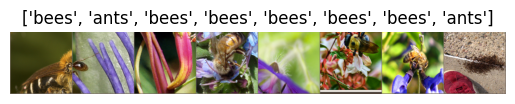

In [37]:
# 학습 데이터로더('train')
d_iter = iter(dloaders['train'])
# 이터레이터에서 다음 미니배치 가져옴
imgs, cls = next(d_iter)
# 이미지를 하나의 격자로 표현
grid = torchvision.utils.make_grid(imgs)

# 격자 이미지오 ㅏ해당 레이블 제목 설정
imageshow(grid, text=[classes[x] for x in cls])

In [ ]:
# 전이학습(transfer learning) 함수정의
def finetune_model(pretrained_model, loss_func, optim, epochs=10):
    # 학습시간 기록
    start = time.time()
    # 현재 모델의 가중치(state_dict)를 깊은 복사 >> 초기상태 저장
    best_model_wts = copy.deepcopy(pretrained_model.state_dict())

    accuracy = 0.0
    for e in range(epochs):
        print(f'epoch_number {e} / {epochs-1}')
        print('='*20)

        for dset in ['train', 'val']:
            if dset == 'train':
                pretrained_model.train()
            else:
                pretrained_model.eval()

            loss = 0.0
            success = 0 # This is initialized

            for imgs, tgts in dloaders[dset]:
                imgs = imgs.to(dvc)
                tgts = tgts.to(dvc)
                optim.zero_grad()

                with torch.set_grad_enabled(dset == 'train'):
                    ops = pretrained_model(imgs)
                    _, preds = torch.max(ops, 1)
                    loss_curr = loss_func(ops, tgts)

                    if dset == 'train':
                        loss_curr.backward()
                        optim.step()

                # 전체손실 누적 <> 배치 손실X
                loss += loss_curr.item() * imgs.size(0)

                # 예측과 정답 일치 개수 세어서
                success += torch.sum(preds ==tgts.data) # Changed 'successes' to 'success'

        # dset_sizes[dset] : 데이터셋의 전체 크기
        loss_epoch = loss / dset_sizes[dset]
        # double. 텐서의 데이터 타입을 부동소수점으로 바꿈
        acc_epoch = success.double() / dset_sizes[dset]
        print(f'{dset} loss in this epoch: {loss_epoch}, accuracy in this epoch: {acc_epoch}')

        if dset == 'val' and acc_epoch > accuracy: # 'acc' changed to 'accuracy'
            accuracy = acc_epoch
            model_weights = copy.deepcopy(pretrained_model.state_dict())
        print()

    # 학습 종료시간 >> 총 소요시간 출력
    time_delta = time.time() - start
    print(f'training finish in {time_delta // 60}mins {time_delta % 60}secs')
    print(f'best acc : {accuracy}') # 'acc' changed to 'accuracy'

    # 최고 성능을 보였던 시점의 모델 가중치(model_weights)를 모델에 로드
    pretrained_model.load_state_dict(model_weights)

    return pretrained_model

In [53]:
# 모델 시각화 함수
# pretrained_model : 사전학습 모델, max_num_imgs : 표시할 최대 이미지 수
def visualize_predictions(pretrained_model, max_num_imgs=4):
    # 난수 생성기 seed 설정
    torch.manual_seed(1)
    # 모델의 원래 학습모드 상태(T/F)로 저장
    was_model_training = pretrained_model.training
    # 모델을 평가모드로 전환
    pretrained_model.eval()
    # 시각화할 이미지 카운터 0으로 초기화
    imgs_counter = 0
    fig = plt.figure()

    # gradient 계산
    with torch.no_grad():
        for i, (imgs, tgts) in enumerate(dloaders['val']):
            imgs, tgts = imgs.to(dvc), tgts.to(dvc)
            ops = pretrained_model(imgs)
            _, preds = torch.max(ops, 1)

            # 현재 배치 내에서 모든 이미지에 대해 순회
            for j in range(imgs.size()[0]):
                imgs_counter += 1
                ax = plt.subplot(max_num_imgs//2, 2, imgs_counter)
                ax.axis('off')

                ax.set_title(f'pred: {classes[preds[j]]} || target: {classes[tgts[j]]}')
                # 역정규화
                imageshow(imgs.cpu().data[j])
                # 최대 이미지 수 도달 시
                if imgs_counter == max_num_imgs:
                    # 모델의 모드를 원상 복구
                    pretrained_model.train(mode=was_model_training)
                    return
    # loop 끝에서 모드를 원상복구
    pretrained_model.train(mode=was_model_training)

In [56]:
# torchvision.models에서 AlexNet 모델 로드
# pretrained=True
model_finetuned = models.alexnet(pretrained=True) # deprecated soon(changed to weights)
model_finetuned.classifier[6] = nn.Linear(4096, 2)
print(model_finetuned.features)
print(model_finetuned.classifier)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True

In [59]:
loss_func = nn.CrossEntropyLoss()
optim_finetune = optim.SGD(model_finetuned.parameters(), lr=0.0001)

model_finetuned = model_finetuned.to(dvc)

model_finetune = finetune_model(model_finetuned, loss_func, optim_finetune, epochs=10)
model_finetune

epoch_number 0 / 9
val loss in this epoch: 0.359146796020807, accuracy in this epoch: 0.8562091503267975

epoch_number 1 / 9
val loss in this epoch: 0.3386357289318945, accuracy in this epoch: 0.869281045751634

epoch_number 2 / 9
val loss in this epoch: 0.3205010344584783, accuracy in this epoch: 0.8758169934640523

epoch_number 3 / 9
val loss in this epoch: 0.308219599908863, accuracy in this epoch: 0.8758169934640523

epoch_number 4 / 9
val loss in this epoch: 0.298658564832865, accuracy in this epoch: 0.8823529411764706

epoch_number 5 / 9
val loss in this epoch: 0.2891633513998362, accuracy in this epoch: 0.9019607843137255

epoch_number 6 / 9
val loss in this epoch: 0.2841913517004524, accuracy in this epoch: 0.9019607843137255

epoch_number 7 / 9
val loss in this epoch: 0.27798747675481184, accuracy in this epoch: 0.9019607843137255

epoch_number 8 / 9
val loss in this epoch: 0.2719864005989888, accuracy in this epoch: 0.9084967320261438

epoch_number 9 / 9
val loss in this epoc

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

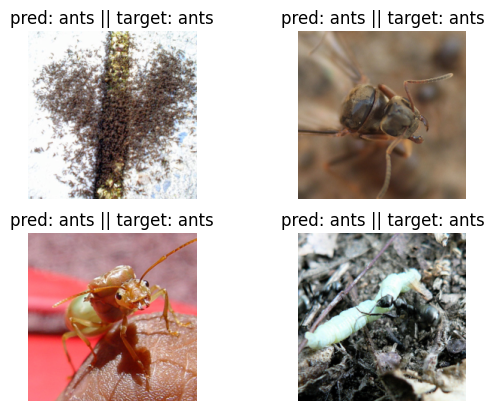

In [60]:
visualize_predictions(model_finetune)